# Problem Set #4
## MACS 30150, Dr. Evans 

## Question 1

In [1027]:
import numpy as np
import scipy.stats as sts
import requests

In [1028]:
url = ("https://raw.github.com/UC-MACSS/persp-model-econ_W19/" +
       "master/ProblemSets/PS4/data/incomes.txt")
data_file = requests.get(url, allow_redirects=True)
open('data/incomes.txt', 'wb').write(data_file.content)
pts = np.loadtxt("data/incomes.txt", delimiter="\n")
pts = np.array(pts)

### Question 1(a)

<IPython.core.display.Javascript object>


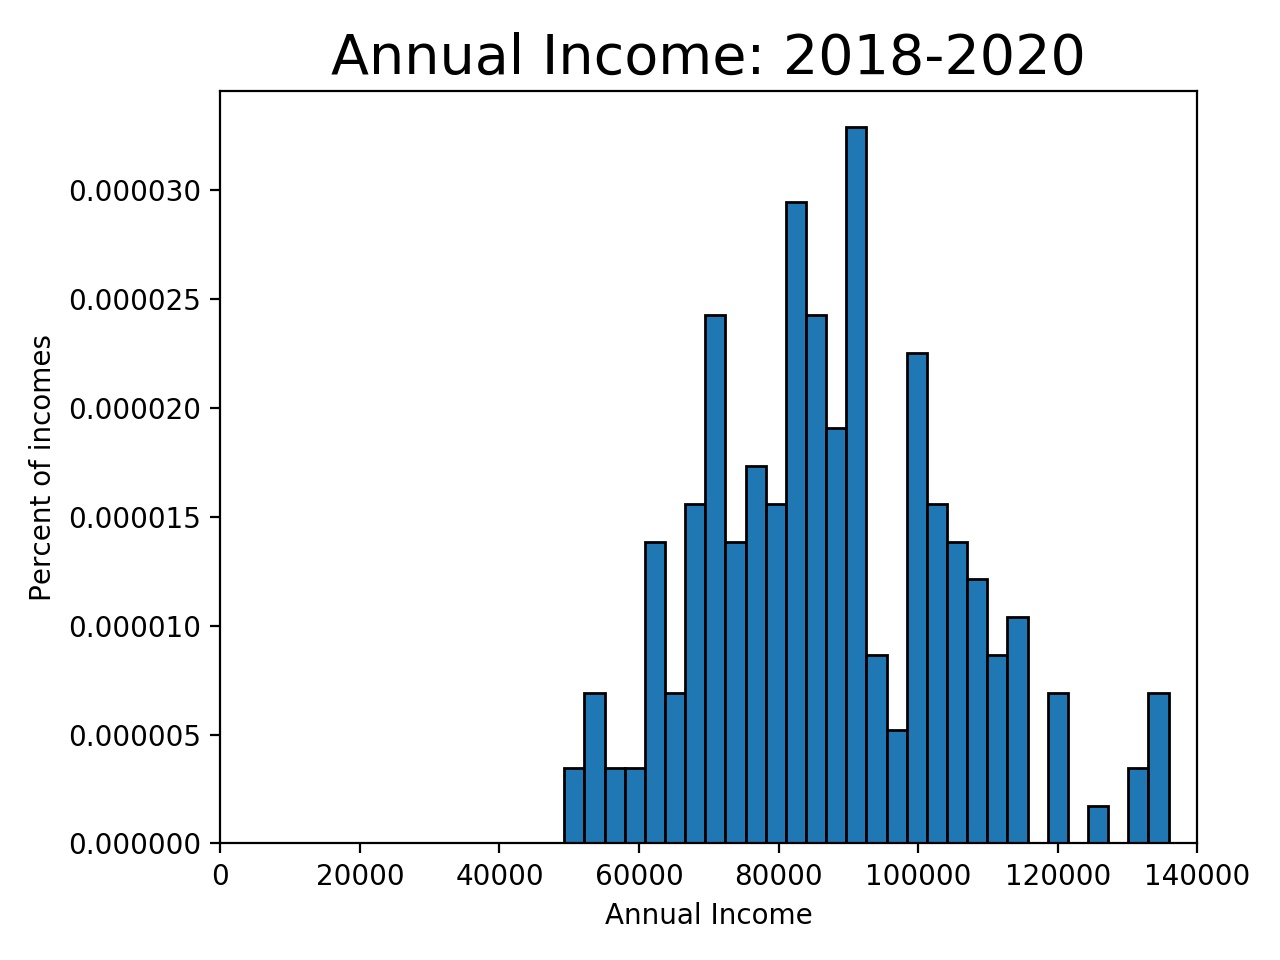

In [1029]:
import matplotlib.pyplot as plt
%matplotlib notebook

num_bins = 30
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title('Annual Income: 2018-2020', fontsize=20)
plt.xlabel(r'Annual Income')
plt.ylabel(r'Percent of incomes')
plt.xlim([0, 140000])  # This gives the xmin and xmax to be plotted"
plt.tight_layout()

## Question 1(b)

In [1030]:
# Define function that generates values of a normal pdf
def log_norm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the normal pdf with mean mu and standard
    deviation sigma. If the cutoff is given, then the PDF values are
    inflated upward to reflect the zero probability on values above the
    cutoff. If there is no cutoff given, this function does the same
    thing as sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.norm.cdf(cut_lb, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.norm.cdf(cut_ub, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.norm.cdf(cut_ub, loc=mu, scale=sigma) -
                       sts.norm.cdf(cut_lb, loc=mu, scale=sigma))    
    denom = ((np.array(xvals) * sigma) * np.sqrt(2 * np.pi))
    pdf_vals    = ((1/denom *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)

    return pdf_vals

<IPython.core.display.Javascript object>


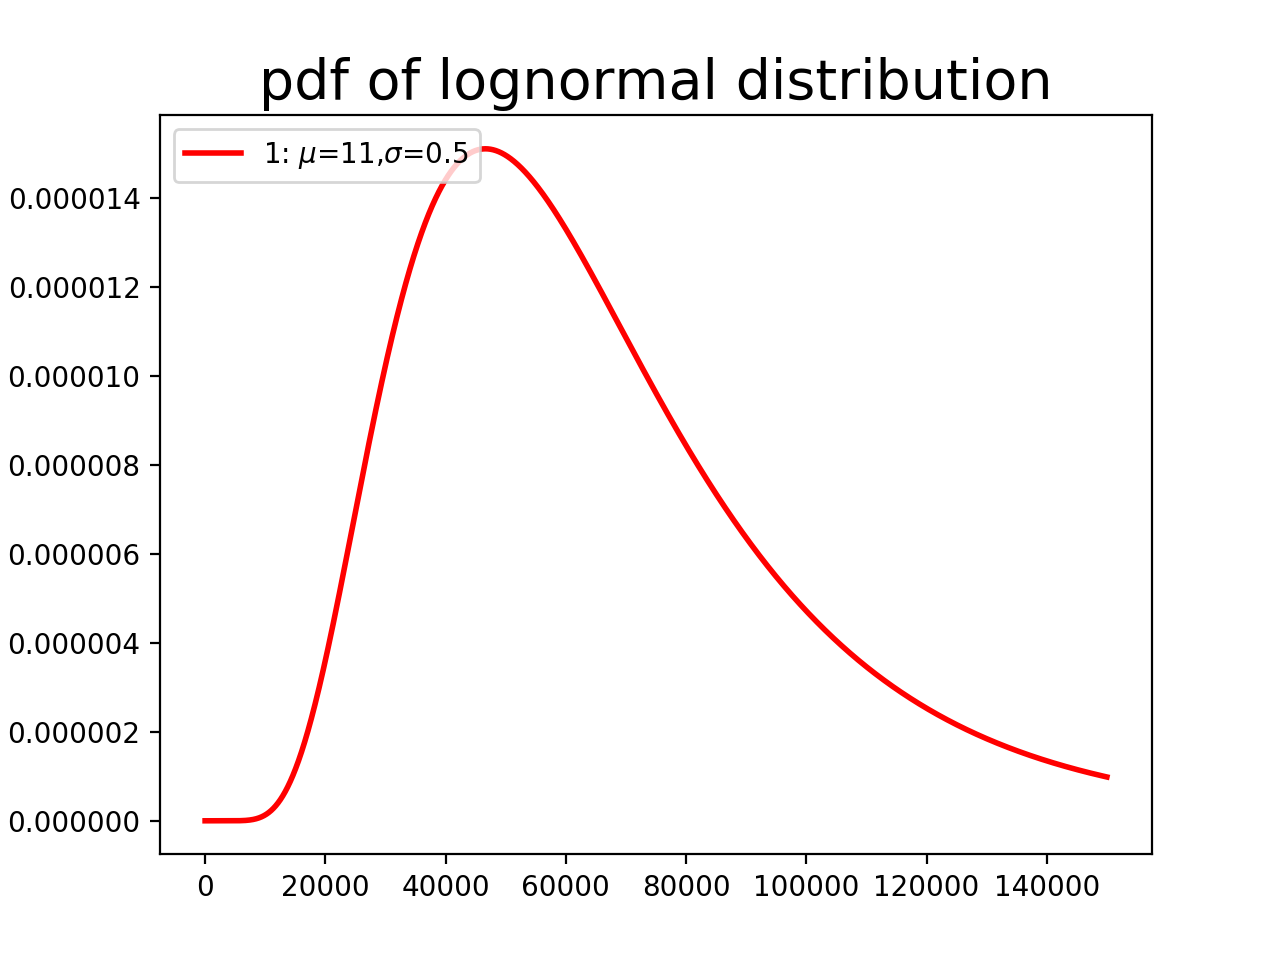

In [1031]:

dist_pts = np.linspace(1e-10, 150000, 200000)
mu = 11
sig = 0.5
pdf_vals = log_norm_pdf(dist_pts, mu, sig, 0, 150000)
plt.plot(dist_pts, pdf_vals,
         linewidth=2, color='r', label='1: $\mu$=11,$\sigma$=0.5')
plt.title('pdf of lognormal distribution', fontsize=20)
plt.legend(loc='upper left')

In [1032]:
def log_lik_lognorm(xvals, mu, sigma, cut_lb, cut_ub):
    '''
    --------------------------------------------------------------------
    Compute the log likelihood function for data xvals given normal
    distribution parameters mu and sigma.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        log_norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals    = (N,) vector, normal PDF values for mu and sigma
                  corresponding to xvals data
    ln_pdf_vals = (N,) vector, natural logarithm of normal PDF values
                  for mu and sigma corresponding to xvals data
    log_lik_val = scalar, value of the log likelihood function
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: log_lik_val
    --------------------------------------------------------------------
    '''
    pdf_vals = log_norm_pdf(xvals, mu, sigma, cut_lb, cut_ub)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

mu = 11
sig = 0.5
print('Log-likelihood 1: ', log_lik_lognorm(pts, mu, sig, 0, 150000))

Log-likelihood 1:  -2385.856997808558


The value of log-likelihood is -2385.856997808558

## Question 1(c)

In [1033]:
def crit(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, cutoff)
    xvals  = (N,) vector, values of the normally distributed random
             variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        log_lik_lognorm()
    
    OBJECTS CREATED WITHIN FUNCTION:
    log_lik_val = scalar, value of the log likelihood function
    neg_log_lik_val = scalar, negative of log_lik_val
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: neg_log_lik_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cut_lb, cut_ub = args
    log_lik_val = log_lik_lognorm(xvals, mu, abs(sigma), cut_lb, cut_ub)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [1034]:
import scipy.optimize as opt

mu_init = 12  # mu_2
sig_init = 0.5  # sig_2
params_init = np.array([mu_init, sig_init])
mle_args = (pts, 0, 150000)
results_uncstr = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE, sig_MLE = results_uncstr.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)

mu_MLE= 11.359022995991296  sig_MLE= 0.2081773187710709


The MLE estimates for mu and sigma are 11.359 and 0.208 respectively.

In [1035]:
results_uncstr

      fun: 2241.7193013573587
 hess_inv: array([[2.13880185e-04, 1.54923231e-06],
       [1.54923231e-06, 1.08754817e-04]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 18
     njev: 21
   status: 0
  success: True
        x: array([11.359023  ,  0.20817732])

<IPython.core.display.Javascript object>


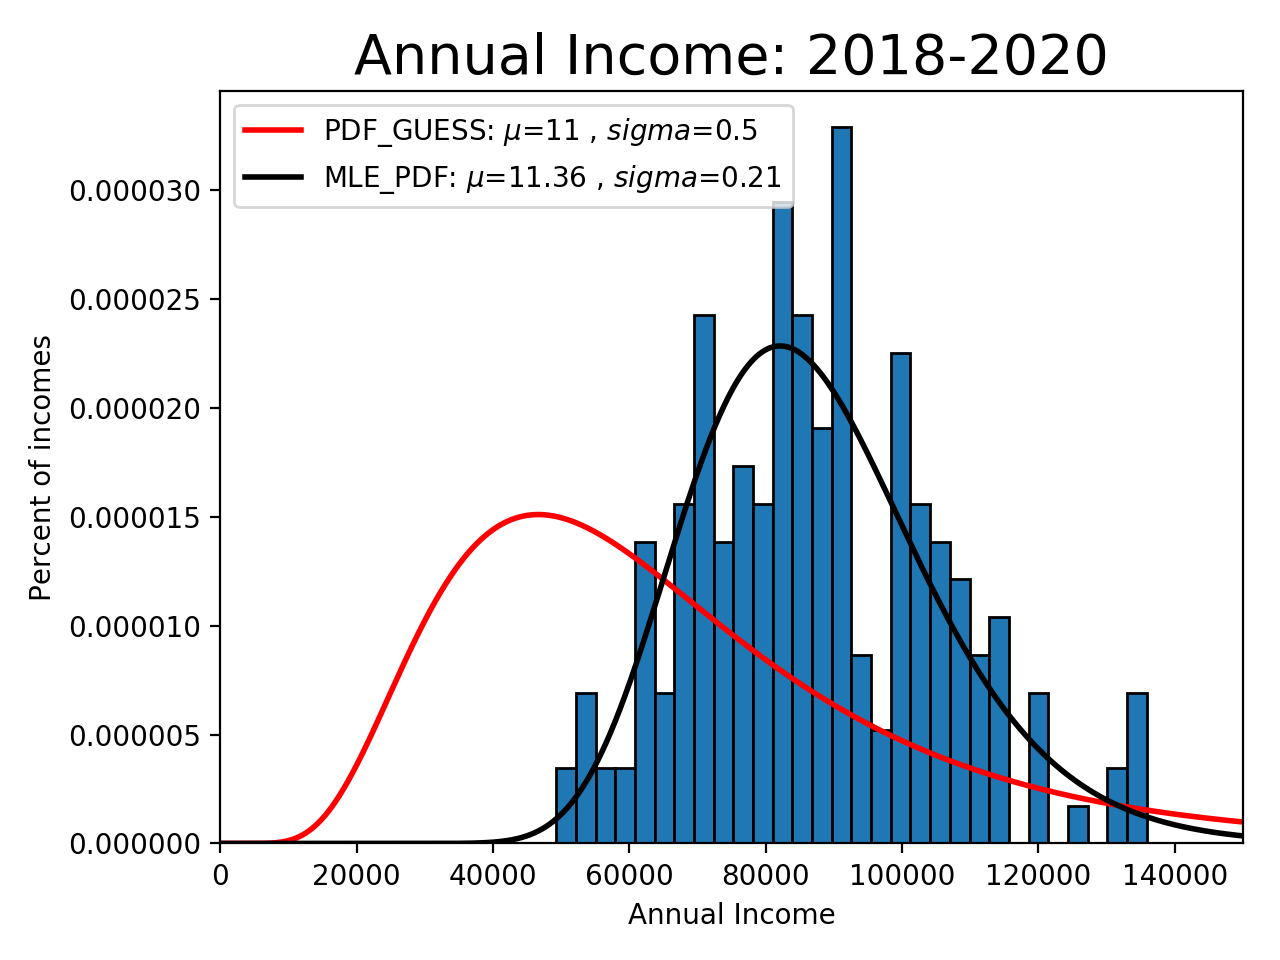

In [1036]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title('Annual Income: 2018-2020', fontsize=20)
plt.xlabel(r'Annual Income')
plt.ylabel(r'Percent of incomes')
plt.xlim([0, 150000])  # This gives the xmin and xmax to be plotted"

# Plot the test distributions from before
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu, sig, 0, 150000),
         linewidth=2, color='r', label='PDF_GUESS: $\mu$=11 ,$\ sigma$=0.5')
plt.legend(loc='upper left')

# Plot the MLE estimated distribution
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_MLE, sig_MLE, 0, 150000),
         linewidth=2, color='k', label='MLE_PDF: $\mu$=11.36 ,$\ sigma$=0.21')
plt.legend(loc='upper left')
plt.tight_layout()

In [1037]:
print('Log-likelihood : ', log_lik_lognorm(pts, mu, sig, 0, 150000))
print('MLE log-likelihood : ', log_lik_lognorm(pts, mu_MLE, sig_MLE, 0, 150000))


Log-likelihood :  -2385.856997808558
MLE log-likelihood :  -2241.7193013573587


The value of likelihood function for initial guess of (11, 0.5) is -2385.85699
The value of likelihood function for MLE estimates is -2241.71930

In [1038]:
results_uncstr
vcv_mle = results_uncstr.hess_inv

print('VCV(MLE) = ', vcv_mle)

VCV(MLE) =  [[2.13880185e-04 1.54923231e-06]
 [1.54923231e-06 1.08754817e-04]]


The variance covariance matrix is [[2.13880185e-04 1.54923231e-06],
 [1.54923231e-06 1.08754817e-04]]

## Question 1(d)

In [1039]:
mu_new, sig_new = np.array([11.0, 0.5])
log_lik_h0 = log_lik_lognorm(pts, mu_new, sig_new, 0, 150000)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_lik_lognorm(pts, mu_MLE, sig_MLE, 0, 150000)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -2385.856997808558
MLE log likelihood -2241.7193013573587
likelihood ratio value 288.2753929023984
chi squared of H0 with 2 degrees of freedom p-value =  0.0


Likelihood ratio test tells us that the probability that the distribution came from initial
guess of mu = 11, sigma = 0.5 is 0

## Question 1(e)

In [1040]:
from scipy.stats import lognorm

#x = np.linspace(0, 150000, 200000)
prob_1 = 1 - lognorm.cdf(100000, s=sig_MLE, loc=0, scale=np.exp(mu_MLE))
prob_2 = lognorm.cdf(75000, s=sig_MLE, loc=0, scale=np.exp(mu_MLE))
print("Probability of earning more than $100,000 is ", prob_1)
print("Probability of earning less than $75,000 is ", prob_2)

Probability of earning more than $100,000 is  0.229866832256036
Probability of earning less than $75,000 is  0.2602342679527267


Probability of earning income more than $100,000 is  0.229866832256036
Probability of earning income less than $75,000 is  0.2602342679527267

## Question 2

## Question 2(a)

In [1041]:
url = ("https://raw.github.com/UC-MACSS/persp-model-econ_W19/" +
       "master/ProblemSets/PS4/data/sick.txt")
data_file = requests.get(url, allow_redirects=True)
open('data/sick.txt', 'wb').write(data_file.content)
pts = np.loadtxt("data/sick.txt", skiprows = 1, delimiter=',')

In [1042]:
y = pts[:,0] # sick
x1 = pts[:,1] # age
x2 = pts[:,2] # number of children
x3 = pts[:,3] # average temperature
MU = 0 #mean

In [1043]:
# Define likelihood function
from scipy.stats import norm

def likelihood_func(y, x1, x2, x3, b0, b1, b2, b3, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the normal pdf with mean mu and standard
    --------------------------------------------------------------------
    INPUTS:
    y, x1, x2, x3 : numpy arrays corresponding to sick, age, children
    and average temp. variables
    b0, b1, b2, b3: coefficients of variables: age, children and 
    average temp., respectively
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: likelihood function values
    --------------------------------------------------------------------
    '''
    return norm(MU, sigma).pdf((y - b0 - b1*x1 - b2*x2 - b3*x3))

In [1044]:
def log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, sigma):
    vals = likelihood_func(y, x1, x2, x3, b0, b1, b2, b3, sigma)
    ln_vals = np.log(vals)
    log_lik_val = ln_vals.sum()
    
    return log_lik_val


In [1045]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

def new_crit(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    INPUTS:
    params = (5,) vector, ([b0, b1, b2, b3, sigma])
    args   = y, x1, x2, x3

    OBJECTS CREATED WITHIN FUNCTION:
    log_lik_val = scalar, value of the log likelihood function
    neg_log_lik_val = scalar, negative of log_lik_val
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: neg_log_lik_val
    --------------------------------------------------------------------
    '''
    b0, b1, b2, b3, sigma = params
    y, x1, x2, x3 = args
    log_likelihood_val = log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, abs(sigma))
    neg_log_likelihood_val = -log_likelihood_val
    
    return neg_log_likelihood_val

In [1046]:
import scipy.optimize as opt

b0_init = 1
b1_init = 0
b2_init = 0
b3_init = 0
sigma_init = (0.01)**(0.5)  # sig
params_init = np.array([b0_init, b1_init, b2_init, b3_init, sigma_init])
mle_args = (y, x1, x2, x3)
results_opti = opt.minimize(new_crit, params_init, args=(mle_args))
b0_MLE, b1_MLE, b2_MLE, b3_MLE, sig_MLE = results_opti.x
print('b0_MLE=', b0_MLE, 'b1_MLE=', b1_MLE)
print('b2_MLE=', b2_MLE, 'b3_MLE=', b3_MLE, ' sigma_MLE=', sig_MLE)

b0_MLE= 0.2516463835964595 b1_MLE= 0.012933350044782263
b2_MLE= 0.4005020483060732 b3_MLE= -0.009991673035556618  sigma_MLE= 0.00301768217590055


The estimates using MLE are:
constant, b0_MLE is 0.2516463835964595
coefficient of age variable, b1_MLE is 0.012933350044782263
coefficient of number of children variable, b2_MLE is 0.4005020483060732 
coefficient of average temperature variable, b3_MLE is -0.009991673035556618
MLE estimate for sigma, sig_MLE is 0.00301768217590055

In [1047]:
results_opti.x

array([ 0.25164638,  0.01293335,  0.40050205, -0.00999167,  0.00301768])

In [1048]:
a = log_lik_norm(y, x1, x2, x3, b0=b0_MLE, b1=b1_MLE, b2=b2_MLE, b3=b3_MLE, sigma=sig_MLE)
print("Log likelihood of MLE estimates is ", a)

Log likelihood of MLE estimates is  876.8650462889004


The value of the log likelihood function is  876.8650462889004

In [1049]:
results_opti
vcv_mle = results_opti.hess_inv


print('VCV(MLE) = ', vcv_mle)

VCV(MLE) =  [[ 1.64074183e-06  1.64966970e-08 -1.37777662e-07 -4.95584136e-08
  -2.88040130e-07]
 [ 1.64966970e-08  6.38608181e-10 -1.03684318e-09 -9.58113592e-10
  -3.61066097e-09]
 [-1.37777662e-07 -1.03684318e-09  1.18584810e-08  3.81099394e-09
   2.36822671e-08]
 [-4.95584136e-08 -9.58113592e-10  3.81099394e-09  1.96901265e-09
   9.35036963e-09]
 [-2.88040130e-07 -3.61066097e-09  2.36822671e-08  9.35036963e-09
   5.21403610e-08]]


The estimated variance-covariance matrix is:
    VCV(MLE) =  [[ 1.64074183e-06  1.64966970e-08 -1.37777662e-07 -4.95584136e-08
  -2.88040130e-07]
 [ 1.64966970e-08  6.38608181e-10 -1.03684318e-09 -9.58113592e-10
  -3.61066097e-09]
 [-1.37777662e-07 -1.03684318e-09  1.18584810e-08  3.81099394e-09
   2.36822671e-08]
 [-4.95584136e-08 -9.58113592e-10  3.81099394e-09  1.96901265e-09
   9.35036963e-09]
 [-2.88040130e-07 -3.61066097e-09  2.36822671e-08  9.35036963e-09
   5.21403610e-08]]

## Question 2(b)

In [1050]:
b0_, b1_, b2_, b3_, sig_ = np.array([1.0, 0, 0, 0, np.sqrt(0.01)])
log_lik_h0 = log_lik_norm(y, x1, x2, x3, b0=b0_, b1=b1_, b2=b2_, b3=b3_, sigma=sig_)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_lik_norm(y, x1, x2, x3, b0=b0_MLE, b1=b1_MLE, b2=b2_MLE, b3=b3_MLE, sigma=sig_MLE)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 5 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -2253.700688042125
MLE log likelihood 876.8650462889004
likelihood ratio value 6261.131468662051
chi squared of H0 with 5 degrees of freedom p-value =  0.0


We reject the null hypothesis that age, number of children,
and average winter temperature have no effect on the number of sick days